In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud
from PIL import Image

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Downloading the dataset of wines

In [6]:
wine_dataset = 'https://media.githubusercontent.com/media/MaryPetrichenko/wine_project/main/winemag-data-130k-v2.csv'
df = pd.read_csv(wine_dataset)

In [7]:
df.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


# Data exploration

The datatypes in the dataset are mostly text information except for the "id" and "price" columns.

In [8]:
df.dtypes

id                         int64
country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object


The dataset contains approximately 130 thousand rows of wine data. It includes wines from 43 different countries, with a total of 707 unique varieties represented.

In [9]:
print(df.shape)

(129971, 14)


In [10]:
selected_columns = ['title', 'country', 'variety', 'winery', 'description']
unique_counts = df[selected_columns].nunique()
unique_counts_df = pd.DataFrame(unique_counts)
unique_counts_df.columns = ['Number of unique values']
unique_counts_df

,Number of unique values
title,118840
country,43
variety,707
winery,16757
description,119955


The most popular wine varieties are Pinot Noir, Chardonnay, Cabernet Sauvingon.

In [11]:
df[['variety']].value_counts()

variety                 
Pinot Noir                  13272
Chardonnay                  11753
Cabernet Sauvignon           9472
Red Blend                    8946
Bordeaux-style Red Blend     6915
                            ...  
Tempranillo-Malbec              1
Malbec-Carménère                1
Malagouzia-Chardonnay           1
Tempranillo-Tannat              1
Žilavka                         1
Name: count, Length: 707, dtype: int64

##Null values

In [12]:
df.isnull().sum()

id                           0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

The dataset has 63 rows with null values in the "country" column. Let's fill in the countries if it can be done by knowing the title.

In [13]:
def country_fill(df):
  """
  The function takes first words in 'title' column before digits representing the year for the rows with null values in 'country' column
  and searches through the dataframe in other rows to get the country and fills null values if found any
  """

  pattern = r'^(.*?)(?=\b\d{4}\b)'  #find the first words before digits representing the year
  titles = list(df[df.country.isnull()].title) # list of titles with null values as countries
  title_country_dict = {} # a dictionary to keep track of matching titles and countries
  for title in titles:
    match = re.search(pattern, title)
    countries = [] # a list of found countries
    try:
      matched_string = match.group()
      mask = df['title'].str.contains(matched_string, case=False, na=False)
      countries = list(set(df[mask][df[mask]['country'].notnull()].country)) # a list of unique country values
      if len(countries)==1:
        title_country_dict[matched_string] = countries[0]
    except:
      AttributeError

  for key, value in title_country_dict.items():
    mask = df['title'].str.contains(key, case=False, na=False)
    df.loc[mask, 'country'] = df.loc[mask, 'country'].fillna(value) # replaces all nulls with the found country names


In [14]:
country_fill(df) # applying the function to fill in the cmissing values in the "country" column

In [15]:
df['country'].isnull().sum() # after applying the country_fill function only 29 rows have null values in the "country" column

29

In [16]:
df.dropna(subset =['country', 'variety'], inplace = True) #dropping the null values in "country" column

## Duplicates

If the dataset doesn't contain duplicate rows but has duplicated descriptions that are supposed to be unique, it's decided to drop the rows with duplicated descriptions for data exploration purposes.

In [17]:
df.duplicated().sum()

0

In [18]:
df[['description', 'variety']].duplicated().sum()

10005

In [19]:
df = df.drop_duplicates(subset=['description', 'variety'])

## Wine types

The dataset lacks information on wine types such as red wine, white wine, rosé, etc. However, we can infer wine types based on the variety of grapes used in making the wine, or the wine title and designation coolumns. Let's assign all the wines to the 4 major types: red, white, rosé and sparkling.







In [20]:
def check_if_any_of_list(row, columns, lst):
    for col in columns:
        try:
            if any(item.lower() in row[col].lower() for item in lst):
                return True
        except:
            continue
    return False

def get_wine_type(row, column, wine_types):
    for key, value in wine_types.items():
        if check_if_any_of_list(row, [column], value):
            return key
    return None

In [21]:
# Colours of wine

red = ['pinot noir', 'st. laurent,', 'zweigelt', 'gamay', 'sangiovese', 'garnacha', 'syrah', 'malbec', 'mourvèdre', 'cabernet sauvignon', 'merlot', 'nebbiolo',
       'tempranillo-merlot', 'red blend', 'frappato', 'nerello mascalese', "nero d'avola", 'bordeaux-style red blend', 'tempranillo blend', 'portuguese red', 'rhône-style red blend',
       'tempranillo', 'cabernet merlot', 'shiraz', 'petite sirah', 'sangiovese grosso', 'corvina, rondinella, molinara', 'carmenère', 'grenache', 'barbera', 'dolcetto',
       'montepulciano', 'pinot nero', 'blaufränkisch', 'aglianico', 'mencía', 'touriga nacional', 'tinta de toro', 'tannat', 'petit verdot', 'monastrell', 'cabernet sauvignon-merlot',
       'pinotage', 'bonarda', 'sagrantino', 'cabernet sauvignon-syrah', 'tinto fino', 'malbec-merlot', 'st. laurent', 'negroamaro', 'cabernet blend', 'lagrein', 'carignan','spätburgunder',
       'provence red blend', 'austrian red blend', 'malbec-cabernet sauvignon', 'syrah-grenache', 'tempranillo-cabernet sauvignon', 'alicante bouschet', 'grenache-syrah', 'prugnolo gentile',
       'cabernet sauvignon-carmenère', 'graciano', 'pedro ximénez', 'shiraz-cabernet sauvignon', 'shiraz-viognier', 'syrah-cabernet sauvignon', 'saperavi', 'merlot-cabernet sauvignon',
       'lemberger', 'castelão', 'xinomavro', 'claret', 'teroldego', 'tempranillo-garnacha', 'tannat-cabernet', 'petite verdot', 'carignane', 'touriga nacional-cabernet sauvignon',
       'dornfelder', 'charbono', 'cabernet sauvignon-shiraz', 'trincadeira', 'baga', 'abouriou', 'merlot-cabernet franc', 'cannonau', 'bobal', 'schiava', 'gamay noir', 'corvina', 'cabernet sauvignon-cabernet franc',
       'port', 'primitivo', 'cabernet franc-merlot', 'syrah-mourvèdre', 'monastrell-syrah', 'malbec-syrah', 'touriga nacional blend', 'nero di troia', 'tinto del pais', 'pinot noir-gamay',
       'piedirosso', 'chambourcin', 'cabernet sauvignon-malbec', 'syrah-viognier', 'plavac mali', 'grenache-carignan', 'negrette', 'alfrocheiro', 'baco noir', 'syrah-petite sirah',
       'tannat-cabernet franc', 'malbec-tannat', 'pinot meunier', 'raboso', 'cabernet franc-cabernet sauvignon', 'syrah-cabernet', 'kalecik karasi', 'norton', 'roter veltliner', 'roter']

white = ['pinot grigio', 'albarino', 'vinho verde', 'muscadet', 'sauvignon blanc', 'unoaked chardonnay', 'chenin blanc', 'chardonnay', 'viognier', 'marssanne', 'portuguese white',
         'riesling', 'pinot gris', 'gewürztraminer', 'white blend', 'grüner veltliner', 'cabernet franc', 'bordeaux-style white blend', 'rhône-style white blend', 'pinot blanc', 'sauvignon', 'albariño',
         'torrontés', 'verdejo', 'roussanne', 'turbiana', 'melon', 'vermentino', 'garganega', 'g-s-m', 'verdicchio', 'pinot bianco', 'fiano', 'vernaccia', 'grillo', 'alvarinho', 'sémillon',
         'grenache blanc', 'friulano', 'greco', 'viura', 'sherry', 'falanghina', 'ribolla gialla', 'arneis', 'austrian white blend', 'arinto', 'fumé blanc', 'sauvignon blanc-semillon', 'marsanne',
         'verdelho', 'petit manseng', 'moscatel', 'vidal blanc', 'pecorino', 'semillon-sauvignon blanc', 'trebbiano', 'sylvaner', 'alsace white blend', 'gros and petit manseng', 'weissburgunder',
         'müller-thurgau', 'malvasia', 'assyrtico', 'encruzado', 'traminer', 'silvaner', 'garnacha blanca', 'carricante', 'provence white blend', 'moschofilero', 'chardonnay-viognier', 'zibibbo', 'picolit',
         'aligoté', 'kerner', 'fernão pires', 'chenin blanc-chardonnay', 'rkatsiteli', 'insolia', 'inzolia', 'auxerrois', 'loureiro', 'scheurebe', 'gros manseng', 'catarratto', 'viognier-chardonnay',
         'rotgipfler', 'colombard', 'welschriesling', 'macabeo', 'jacquère', 'passerina', 'verdejo-viura', 'muskat ottonel', 'marsanne-roussanne', 'savagnin', 'tocai friulano', 'orange muscat', 'xarel-lo',
         'colombard-sauvignon blanc', 'palomino', 'picpoul', 'coda di volpe', 'antão vaz', 'assyrtiko', 'hondarrabi zuri', 'seyval blanc', 'moscato giallo', 'malvasia bianca', 'zierfandler',
         'sauvignon gris', 'pansa blanca', 'white riesling', 'chenin blanc-viognier', 'albana', 'moscato', 'muscat', 'furmint', 'tokaji']


rose = ['rose', 'rosé', 'rosato', 'rosado', 'portuguese rosé']

sparkling = ['lambrusco', 'glera', 'champagne blend', 'sparkling blend', 'prosecco', 'portuguese sparkling', 'sparkling', 'frizzante', 'lambrusco di sorbara', 'lambrusco grasparossa', 'sparkling']

wine_types = {
    'red': red,
    'white': white,
    'rose': rose,
    'sparkling': sparkling
}

for index, row in df.iterrows():
    # Check variety field
    type_by_variety = get_wine_type(row, 'variety', wine_types)

    # Correct the type if found in title or designation
    type_by_title = get_wine_type(row, 'title', wine_types)
    type_by_design = get_wine_type(row, 'designation', wine_types)

    # Assign the final type
    if type_by_design:
        df.at[index, 'type'] = type_by_design
    elif type_by_title:
        df.at[index, 'type'] = type_by_title
    elif type_by_variety:
        df.at[index, 'type'] = type_by_variety
    else:
        df.at[index, 'type'] = 'unknown'

Zinfandel wines can be categorized as red, white, or rosé. By default, I assign them to red wine unless the description in the "title", "designation", or "variety" columns indicates that the wine is white or rosé.

In [22]:
df.loc[(df['variety'].str.contains('zinfandel', case=False, na=False)) &
       (df['designation'].str.contains('rosé', case=False, na=False, regex=True)), 'type'] = 'rose'
df.loc[(df['variety'].str.contains('zinfandel', case=False, na=False)) &
       (df['designation'].str.contains('white ', case=False, na=False, regex=True)), 'type'] = 'white'
df.loc[(df['variety'].str.contains('zinfandel', case=False, na=False)) &
       (df['type'].str.contains('unknown', case=False, na=False, regex=True)), 'type'] = 'red'

In [23]:
df['type'].value_counts() # after applying these functions there are ~1,4 thousands rows where the wine tyope was not defined.

type
red          72049
white        38124
rose          5675
sparkling     2650
unknown       1438
Name: count, dtype: int64

In [24]:
df = df[df['type'] != 'unknown'] # dropping the rows with the unknown type of wine

# Visualizing Wine Datasets




For data exploration purposes, a new column named "compound description" was created. This column combines the text from the following columns: "description", "variety", "province", and "title".

In [25]:
# Create a column that combines wine description, title, province and variety.
cols = ['description', 'variety', 'province', 'title']
df['compound_description'] = df.apply(lambda row: ' '.join(str(row[col]) for col in cols), axis=1)

In [26]:
df['compound_description'][0] #this is how the compound description can look like

"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity. White Blend Sicily & Sardinia Nicosia 2013 Vulkà Bianco  (Etna)"

The most effective method for visualizing textual information is a word cloud. I can utilize it with the compound description. However, before generating the word cloud, I need to filter out common words that do not provide specific information about the wine.

In [27]:
# Create a list of stopwords that can be seen in any type of wine

type_custom_stopwords = ['wine', 'red', 'flavors', 'blend', 'rosé', 'acidity', 'de', 'sparkling', 'champagne', 'white', 'blanc', 'aromas', 'valley', 'tannins', 'palate', 'nv',
                        'finish', 'drink', 'california', 'provence', 'château', 'côtes', 'cabernet', 'pinot', 'sauvingon', 'vineyard', 'notes', 'brut', 'cava', 'cuvée', 'nose',
                        'noir', 'fruit', 'fruity', 'fruits', 'dry', 'texture', 'color', 'touch', 'well', 'balanced', 'character', 'sauvignon', 'offers', 'fine', 'full', 'fine',
                        'made', 'good', 'years', 'la', 'shows', 'sample','rich']

In [28]:
def most_frequent_words(df, colname, custom_stopwords, num):
    frequent_words = {}
    grouped = df.groupby(colname)['compound_description'].apply(' '.join)
    stop_words = set(nltk.corpus.stopwords.words('english'))

    # Add custom stop words that can be found in any type of wine and do not bring value to wine descriptions
    stop_words.update(custom_stopwords)

    for key, description in grouped.items():
        words = word_tokenize(description.lower())
        words = [word for word in words if word.isalnum() and len(word) > 1 and word not in stop_words]
        word_freq = Counter(words)

        n = num
        frequent_words[key] = word_freq.most_common(n)
    return frequent_words


In [29]:
type_words = most_frequent_words(df, 'type', type_custom_stopwords, 100)

Here we can see the most frequent words that appear in the red wine description.



In [30]:
for type, words in type_words.items():
    print(f"Wine Type: {type}")
    print("Most frequent words:")
    for word, freq in words:
        print(f"- {word}: {freq}")
    print()

Wine Type: red
Most frequent words:
- cherry: 23188
- black: 22777
- ripe: 15108
- berry: 13287
- spice: 12924
- syrah: 11935
- plum: 11799
- oak: 11603
- blackberry: 11317
- merlot: 10839
- dark: 9844
- 2012: 9666
- 2013: 8938
- soft: 8207
- 2010: 7911
- 2011: 7751
- firm: 7579
- 2014: 7568
- raspberry: 7515
- pepper: 7467
- chocolate: 7321
- malbec: 7001
- 2009: 6845
- bordeaux: 6695
- fresh: 6602
- sweet: 6573
- juicy: 6517
- washington: 6158
- zinfandel: 5989
- vanilla: 5971
- structure: 5637
- sangiovese: 5528
- tannic: 5502
- dried: 5361
- licorice: 5316
- estate: 5159
- 2008: 5083
- light: 5079
- tuscany: 5055
- bright: 5044
- spicy: 4766
- 2007: 4729
- leather: 4704
- currant: 4646
- smooth: 4549
- tobacco: 4546
- herbal: 4528
- herb: 4371
- dense: 4354
- wood: 4332
- di: 4293
- mendoza: 4193
- cassis: 4043
- earthy: 4027
- 2006: 3914
- concentrated: 3912
- oregon: 3871
- napa: 3832
- new: 3829
- structured: 3804
- cola: 3755
- cherries: 3688
- give: 3678
- also: 3644
- coffee:

In [31]:
mask = np.array(Image.open('./wine.webp'))
mask = np.apply_along_axis(lambda x: 255 if x[0] == 0 else x[0], axis=2, arr=mask)

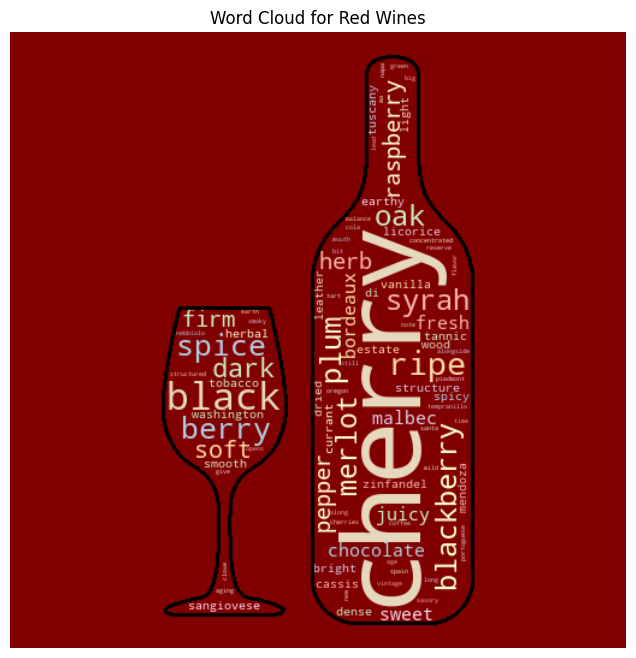

In [32]:
red_wine_words = ''
for word, freq in type_words['red']:
    red_wine_words += (word + ' ') * freq
wc = WordCloud(background_color="maroon", max_words=1000,
               max_font_size=90, contour_width=3,
               collocations=False, colormap = "Pastel1", mask = mask)
wc.generate(red_wine_words)
plt.figure(figsize = (15,8))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word Cloud for Red Wines')
plt.axis('off')
plt.show()

Here we can see the most frequent words that appear in the white wine description.

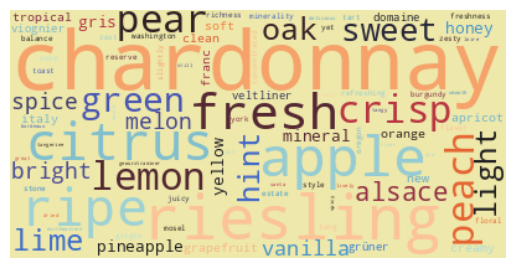

In [106]:
white_wine_words = ''
for word, freq in type_words['white']:
    white_wine_words += (word + ' ') * freq
wc = WordCloud(background_color="palegoldenrod", max_words=1000,
               max_font_size=90, contour_width=3,
               collocations=False, colormap = "icefire")
wc.generate(white_wine_words)
plt.figure()
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

Here we can identify the top 10 most popular wine varieties.

In [107]:
# Identify most frequent varieties in our data
variety_counts = pd.DataFrame(df['variety'].value_counts().head(10))
variety_counts.reset_index(inplace=True)
variety_counts.columns = ['Variety', 'Count']
variety_counts

,Variety,Count
0,Pinot Noir,12277
1,Chardonnay,10865
2,Cabernet Sauvignon,8838
3,Red Blend,8232
4,Bordeaux-style Red Blend,6469
5,Riesling,4772
6,Sauvignon Blanc,4575
7,Syrah,3826
8,Rosé,3220
9,Merlot,2896


In [108]:
# get list of the varieties and indentify the words that describe it
top_varieties = list(variety_counts['Variety'])
top_varieties

['Pinot Noir',
 'Chardonnay',
 'Cabernet Sauvignon',
 'Red Blend',
 'Bordeaux-style Red Blend',
 'Riesling',
 'Sauvignon Blanc',
 'Syrah',
 'Rosé',
 'Merlot']

In [109]:
# Update the stop words list for describing the varieties
var_stop_words = ['bordeaux', 'merlo', 'franc', 'structure', 'napa','washington', 'burgundy', 'columbia', 'oregon', 'river', 'russian', 'hills', 'estate', 'santa',
                  'tuscany', 'alongside', 'di', 'york','attractive', 'grenache', 'marlborough','loire', 'sancerre', 'walla', 'wa', 'chardonnay', 'merlot', 'reserve',
                  'willamette', 'coast', 'sangiovese','merlot','syrah','sangiovese','riesling','mosel','alsace','new','domaine', 'opens', 'sonoma', 'yet', 'lakes',
                  'casablanca', 'structured', 'long', 'finger', 'county', 'barrel', 'rheingau']
variety_custom_stopwords = type_custom_stopwords + var_stop_words

In [110]:
top_var_df = df[df['variety'].isin(top_varieties)]
var_words = most_frequent_words(top_var_df, 'variety', variety_custom_stopwords, 20)

In [111]:
for type, words in var_words.items():
    print(f"Wine Variety: {type}")
    print("Most frequent words:")
    for word, freq in words:
        print(f"- {word}: {freq}")
    print()

Wine Variety: Bordeaux-style Red Blend
Most frequent words:
- black: 2152
- ripe: 2100
- firm: 1312
- wood: 1263
- juicy: 1147
- dark: 1025
- 2012: 968
- blackberry: 946
- 2010: 918
- 2014: 876
- spice: 835
- aging: 833
- 2011: 828
- dense: 811
- currant: 792
- berry: 788
- soft: 742
- cherry: 730
- fresh: 705
- 2013: 664

Wine Variety: Cabernet Sauvignon
Most frequent words:
- black: 3207
- cherry: 2685
- oak: 2463
- blackberry: 2238
- cassis: 1580
- chocolate: 1422
- ripe: 1408
- currant: 1301
- plum: 1293
- soft: 1239
- 2012: 1228
- dark: 1205
- berry: 1164
- 2013: 1161
- sweet: 1080
- tannic: 1020
- 2010: 1002
- cab: 986
- spice: 969
- 2009: 959

Wine Variety: Chardonnay
Most frequent words:
- apple: 3411
- oak: 2607
- ripe: 2563
- pear: 1983
- crisp: 1913
- lemon: 1910
- vanilla: 1774
- citrus: 1734
- 2014: 1644
- toast: 1603
- peach: 1535
- pineapple: 1475
- 2013: 1443
- fresh: 1320
- creamy: 1238
- tropical: 1183
- 2012: 1172
- green: 1100
- 2010: 1082
- 2015: 1058

Wine Variety

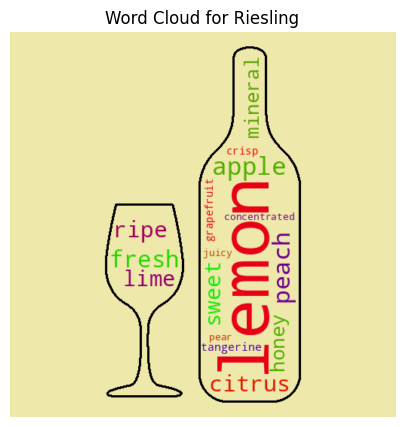

In [112]:
reisling_words = ''
for word, freq in var_words['Riesling']:
    reisling_words += (word + ' ') * freq

wc = WordCloud(background_color="palegoldenrod", max_words=1000, mask=mask,
               max_font_size=90, contour_width=3,
               collocations=False, colormap = "brg")
wc.generate(reisling_words)
plt.figure(figsize = (10,5))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word Cloud for Riesling')
plt.axis('off')
plt.show()

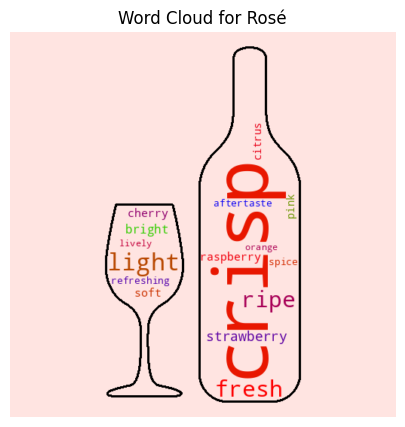

In [113]:
rose_words = ''
for word, freq in var_words['Rosé']:
    rose_words += (word + ' ') * freq



wc = WordCloud(background_color="mistyrose", max_words=1000, mask=mask,
               max_font_size=100, contour_width=3,
               collocations=False, colormap = "brg")
wc.generate(rose_words)
plt.figure(figsize = (10,5))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word Cloud for Rosé')
plt.axis('off')
plt.show()

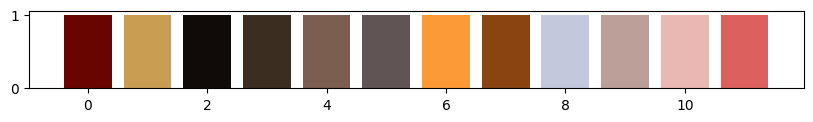

In [114]:
wine_palette = ['#690500', '#C99D52', '#100A09', '#3C2D21', '#7C5E50', '#605554', '#FB9A36', '#894412', '#C3C8DC', '#BC9F99', '#E9B8B2', '#DB605E']
# https://coolors.co/c99d52-100a09-3c2d21-7c5e50-605554-fb9a36-894412-c3c8dc
plt.figure(figsize=(10, 1))
for i, color in enumerate(wine_palette):
    plt.bar(i, 1, color=color)

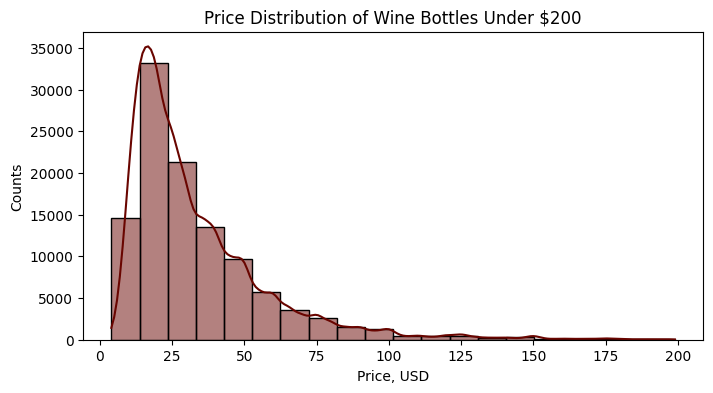

In [115]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df[df['price']<200][['price', 'points','type']], x='price', bins=20, kde=True, color = wine_palette[0])
plt.xlabel('Price, USD')
plt.ylabel("Counts")
plt.title('Price Distribution of Wine Bottles Under $200')
plt.show()

In terms of price, the range is quite diverse, spanning from 4 to 3,300 dollars per bottle. However, the majority of wines fall within a more accessible range, with most priced at under 40 dollars per bottle.

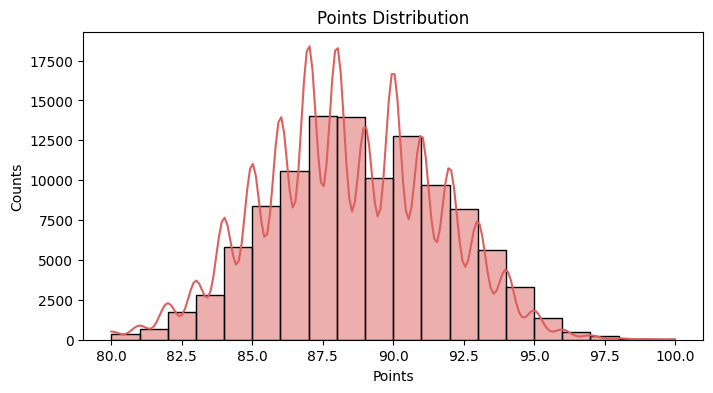

In [116]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df[df['price']<2000000][['price', 'points','type']], x='points', bins=20, kde=True, color = wine_palette[11])
plt.xlabel('Points')
plt.ylabel("Counts")
plt.title('Points Distribution')
plt.show()

The wines are scored between 80 and 100 points, reflecting a range of quality from acceptable to classic, which are described as the pinnacle of quality. The distribution follows a normal pattern with a bell curve shape. Most wines fall within the range of 83 to 92 points, indicating they are considered good, very good, or excellent.

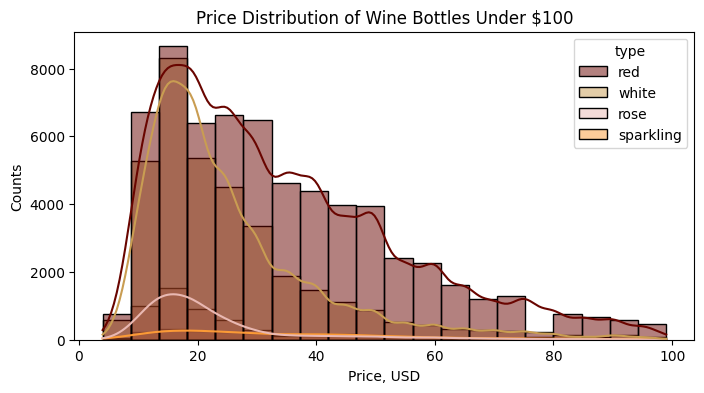

In [117]:
plt.figure(figsize=(8, 4))
type_colors = {'red': wine_palette[0], 'white': wine_palette[1], 'rose': wine_palette[10], 'sparkling': wine_palette[6]}
sns.histplot(data=df[df['price']<100][['price', 'points','type']], x='price', bins=20, kde=True, hue='type', palette=type_colors)
plt.xlabel('Price, USD')
plt.ylabel("Counts")
plt.title('Price Distribution of Wine Bottles Under $100')
plt.show()

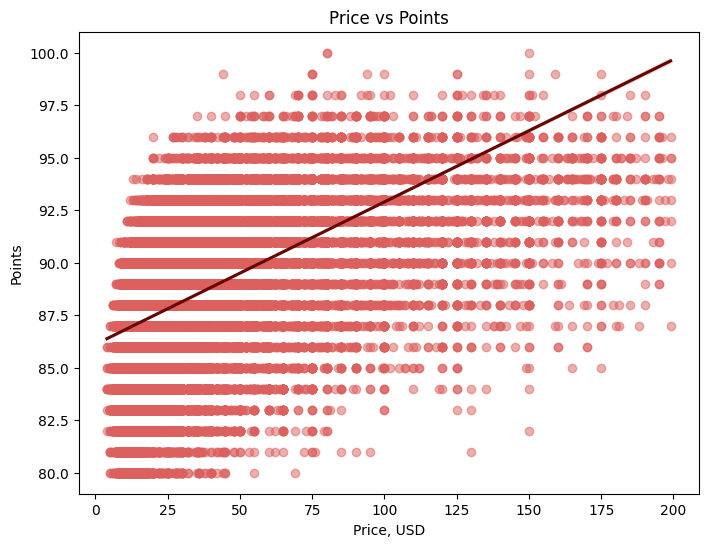

In [118]:
# Create a scatter plot of price versus points with a trend line
plt.figure(figsize=(8, 6))
sns.regplot(data=df[df['price']<200], x='price', y='points', scatter_kws={'alpha': 0.5, 'color': wine_palette[11]}, line_kws={'color': wine_palette[0]})

# Add labels and title
plt.xlabel('Price, USD')
plt.ylabel('Points')
plt.title('Price vs Points')

# Show the plot
plt.show()

When looking at points versus price, I wasn't surprised to find a positive correlation. Well, it makes sense that wines with higher prices often come with better quality. However, it's interesting to see that even in the lowest price ranges, there are still plenty of wines with points higher than 92 – excellent wines.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (9) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (9) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (9) than needed (4), which may not be intended.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (9) than needed (4), which may not be intended.
  func(x=x, y=y, **kwargs)


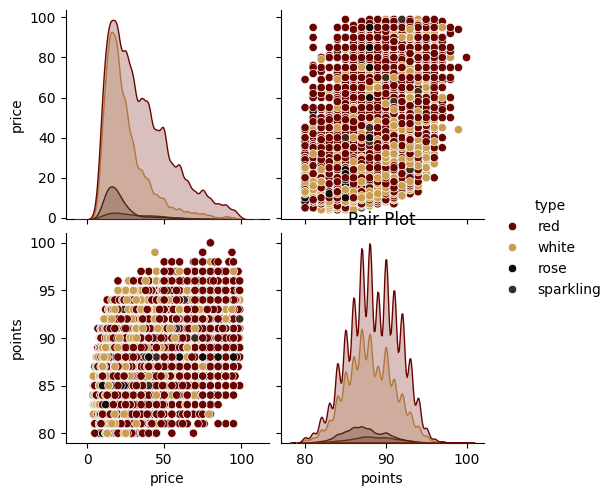

In [119]:
sns.pairplot(data=df[df['price']<100][['price', 'points','type']], hue='type', palette = wine_palette[0:9])
plt.title('Pair Plot')
plt.show()

In [ ]:
# See the colormaps for font here:
# https://i.stack.imgur.com/x3SF8.png

# List of background colors:
# https://matplotlib.org/3.4.3/gallery/color/named_colors.html